In [1]:
2+8

10

In [ ]:
# SmartVision AI - Classification Models Training
# File: 03_classification_models.ipynb
# Train 4 models: VGG16, ResNet50, MobileNetV2, EfficientNetB0

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import json
import time
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

BASE_DIR = "smartvision_dataset/classification"
TRAIN_DIR = f"{BASE_DIR}/train"
VAL_DIR = f"{BASE_DIR}/val"
TEST_DIR = f"{BASE_DIR}/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 25
EPOCHS = 20

# Class names
CLASSES = [
    'airplane', 'bed', 'bench', 'bicycle', 'bird', 'bottle', 'bowl', 'bus',
    'cake', 'car', 'cat', 'chair', 'couch', 'cow', 'cup', 'dog', 'elephant',
    'horse', 'motorcycle', 'person', 'pizza', 'potted plant', 'stop sign',
    'traffic light', 'truck'
]

print("="*80)
print("🚀 SMARTVISION AI - CLASSIFICATION MODELS TRAINING")
print("="*80)
print(f"📊 Training on {NUM_CLASSES} classes")
print(f"🖼️ Image size: {IMG_SIZE}")
print(f"📦 Batch size: {BATCH_SIZE}")
print(f"🔄 Epochs: {EPOCHS}")
print("="*80)
print()

# ============================================================================
# DATA LOADING & AUGMENTATION
# ============================================================================

print("📁 Loading datasets...")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"✅ Train samples: {train_generator.samples}")
print(f"✅ Val samples: {val_generator.samples}")
print(f"✅ Test samples: {test_generator.samples}")
print()

# ============================================================================
# MODEL BUILDING FUNCTIONS
# ============================================================================

def build_vgg16(num_classes=25):
    """Build VGG16 transfer learning model"""
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze base layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


def build_resnet50(num_classes=25):
    """Build ResNet50 transfer learning model"""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Unfreeze last 20 layers for fine-tuning
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


def build_mobilenetv2(num_classes=25):
    """Build MobileNetV2 transfer learning model"""
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze base layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


def build_efficientnetb0(num_classes=25):
    """Build EfficientNetB0 transfer learning model"""
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Unfreeze last 30 layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


# ============================================================================
# TRAINING FUNCTION
# ============================================================================

def train_model(model, model_name, epochs=EPOCHS):
    """Train and evaluate a model"""
    print("="*80)
    print(f"🏋️ Training {model_name}")
    print("="*80)
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')]
    )
    
    # Callbacks
    checkpoint = ModelCheckpoint(
        f'models/{model_name}_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
    
    # Train
    start_time = time.time()
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[checkpoint, early_stop, reduce_lr],
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    # Evaluate on test set
    print("\n📊 Evaluating on test set...")
    test_loss, test_acc, test_top5 = model.evaluate(test_generator, verbose=0)
    
    # Inference time
    print("\n⏱️ Measuring inference time...")
    test_batch = next(iter(test_generator))
    start = time.time()
    _ = model.predict(test_batch[0][:1], verbose=0)
    inference_time = (time.time() - start) * 1000  # ms
    
    results = {
        'model_name': model_name,
        'test_accuracy': float(test_acc),
        'test_top5_accuracy': float(test_top5),
        'test_loss': float(test_loss),
        'training_time_seconds': float(training_time),
        'inference_time_ms': float(inference_time),
        'params': model.count_params()
    }
    
    print(f"\n✅ {model_name} Results:")
    print(f"   Test Accuracy: {test_acc*100:.2f}%")
    print(f"   Top-5 Accuracy: {test_top5*100:.2f}%")
    print(f"   Inference Time: {inference_time:.2f}ms")
    print(f"   Parameters: {model.count_params():,}")
    
    return history, results


# ============================================================================
# TRAIN ALL MODELS
# ============================================================================

# Create models directory
os.makedirs('models', exist_ok=True)

all_results = []
all_histories = {}

# MODEL 1: VGG16
print("\n" + "="*80)
print("MODEL 1/4: VGG16")
print("="*80)
model_vgg16 = build_vgg16(NUM_CLASSES)
history_vgg16, results_vgg16 = train_model(model_vgg16, 'VGG16', epochs=15)
all_results.append(results_vgg16)
all_histories['VGG16'] = history_vgg16

# MODEL 2: ResNet50
print("\n" + "="*80)
print("MODEL 2/4: ResNet50")
print("="*80)
model_resnet = build_resnet50(NUM_CLASSES)
history_resnet, results_resnet = train_model(model_resnet, 'ResNet50', epochs=20)
all_results.append(results_resnet)
all_histories['ResNet50'] = history_resnet

# MODEL 3: MobileNetV2
print("\n" + "="*80)
print("MODEL 3/4: MobileNetV2")
print("="*80)
model_mobilenet = build_mobilenetv2(NUM_CLASSES)
history_mobilenet, results_mobilenet = train_model(model_mobilenet, 'MobileNetV2', epochs=15)
all_results.append(results_mobilenet)
all_histories['MobileNetV2'] = history_mobilenet

# MODEL 4: EfficientNetB0
print("\n" + "="*80)
print("MODEL 4/4: EfficientNetB0")
print("="*80)
model_efficientnet = build_efficientnetb0(NUM_CLASSES)
history_efficientnet, results_efficientnet = train_model(model_efficientnet, 'EfficientNetB0', epochs=20)
all_results.append(results_efficientnet)
all_histories['EfficientNetB0'] = history_efficientnet

# ============================================================================
# SAVE RESULTS
# ============================================================================

# Save all results
with open('models/training_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print("\n" + "="*80)
print("💾 All models saved successfully!")
print("="*80)



🚀 SMARTVISION AI - CLASSIFICATION MODELS TRAINING
📊 Training on 25 classes
🖼️ Image size: (224, 224)
📦 Batch size: 32
🔄 Epochs: 20

📁 Loading datasets...
Found 1750 images belonging to 25 classes.
Found 375 images belonging to 25 classes.
Found 375 images belonging to 25 classes.
✅ Train samples: 1750
✅ Val samples: 375
✅ Test samples: 375


MODEL 1/4: VGG16
🏋️ Training VGG16
Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.0430 - loss: 3.3753 - top5_acc: 0.2088 
Epoch 1: val_accuracy improved from None to 0.02400, saving model to models/VGG16_best.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 2862s 50s/step - accuracy: 0.0411 - loss: 3.3459 - top5_acc: 0.2040 - val_accuracy: 0.0240 - val_loss: 3.2130 - val_top5_acc: 0.2533 - learning_rate: 1.0000e-04
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.0327 - loss: 3.2962 - top5_acc: 0.2042 
Epoch 2: val_accuracy improved from 0.02400 to 0.08000, saving model to models/VGG16_best.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 2736s 49s/step - accuracy: 0.0406 - loss: 3.2680 - top5_acc: 0.2223 - val_accuracy: 0.0800 - val_loss: 3.1974 - val_top5_acc: 0.2000 - learning_rate: 1.0000e-04
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 38s/step - accuracy: 0.0570 - loss: 3.2193 - top5_acc: 0.2618 
Epoch 3: val_accuracy improved from 0.08000 to 0.12000, saving model to models/VGG16_best.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 2639s 48s/step - accuracy: 0.0531 - loss: 3.2279 - top5_acc: 0.2451 - val_accuracy: 0.1200 - val_loss: 3.1769 - val_top5_acc: 0.2987 - learning_rate: 1.0000e-04
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.0488 - loss: 3.2085 - top5_acc: 0.2640 
Epoch 4: val_accuracy did not improve from 0.12000
55/55 ━━━━━━━━━━━━━━━━━━━━ 2708s 49s/step - accuracy: 0.0571 - loss: 3.1954 - top5_acc: 0.2749 - val_accuracy: 0.0800 - val_loss: 3.1587 - val_top5_acc: 0.3200 - learning_rate: 1.0000e-04
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.0740 - loss: 3.1557 - top5_acc: 0.3021 
Epoch 5: val_accuracy did not improve from 0.12000
55/55 ━━━━━━━━━━━━━━━━━━━━ 2649s 48s/step - accuracy: 0.0817 - loss: 3.1574 - top5_acc: 0.3040 - val_accuracy: 0.0827 - val_loss: 3.1242 - val_top5_acc: 0.3253 - learning_rate: 1.0000e-04
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.0757 - loss: 3.1292 - top5_acc: 0.3257 
Epoch 6: val_accuracy 

55/55 ━━━━━━━━━━━━━━━━━━━━ 2659s 48s/step - accuracy: 0.0983 - loss: 2.9945 - top5_acc: 0.3777 - val_accuracy: 0.1493 - val_loss: 2.9892 - val_top5_acc: 0.5280 - learning_rate: 1.0000e-04
Epoch 9/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - accuracy: 0.0979 - loss: 2.9418 - top5_acc: 0.3975 
Epoch 9: val_accuracy improved from 0.14933 to 0.22667, saving model to models/VGG16_best.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 3515s 64s/step - accuracy: 0.0943 - loss: 2.9469 - top5_acc: 0.3971 - val_accuracy: 0.2267 - val_loss: 2.9376 - val_top5_acc: 0.6080 - learning_rate: 1.0000e-04
Epoch 10/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.0952 - loss: 2.9139 - top5_acc: 0.4186 
Epoch 10: val_accuracy did not improve from 0.22667
55/55 ━━━━━━━━━━━━━━━━━━━━ 2672s 48s/step - accuracy: 0.0943 - loss: 2.9078 - top5_acc: 0.4171 - val_accuracy: 0.2133 - val_loss: 2.8944 - val_top5_acc: 0.6000 - learning_rate: 1.0000e-04
Epoch 11/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.0968 - loss: 2.8529 - top5_acc: 0.4526 
Epoch 11: val_accuracy did not improve from 0.22667
55/55 ━━━━━━━━━━━━━━━━━━━━ 2615s 48s/step - accuracy: 0.0897 - loss: 2.8612 - top5_acc: 0.4377 - val_accuracy: 0.1760 - val_loss: 2.8535 - val_top5_acc: 0.5787 - learning_rate: 1.0000e-04
Epoch 12/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.0983 - loss: 2.8132 - top5_acc: 0.4621 
Epoch 12: val_acc

55/55 ━━━━━━━━━━━━━━━━━━━━ 2718s 49s/step - accuracy: 0.1223 - loss: 2.7668 - top5_acc: 0.4903 - val_accuracy: 0.2373 - val_loss: 2.7734 - val_top5_acc: 0.6907 - learning_rate: 1.0000e-04
Epoch 14/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.1073 - loss: 2.7508 - top5_acc: 0.4801 
Epoch 14: val_accuracy improved from 0.23733 to 0.26133, saving model to models/VGG16_best.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 2680s 49s/step - accuracy: 0.1120 - loss: 2.7357 - top5_acc: 0.4869 - val_accuracy: 0.2613 - val_loss: 2.7345 - val_top5_acc: 0.6853 - learning_rate: 1.0000e-04
Epoch 15/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.1157 - loss: 2.7240 - top5_acc: 0.5017 
Epoch 15: val_accuracy did not improve from 0.26133
55/55 ━━━━━━━━━━━━━━━━━━━━ 2631s 48s/step - accuracy: 0.1103 - loss: 2.7224 - top5_acc: 0.4954 - val_accuracy: 0.2027 - val_loss: 2.7021 - val_top5_acc: 0.7147 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.

📊 Evaluating on test set...

⏱️ Measuring inference time...

✅ VGG16 Results:
   Test Accuracy: 20.53%
   Top-5 Accuracy: 72.27%
   Inference Time: 42333.23ms
   Parameters: 15,115,097

MODEL 2/4: ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 48s 1us/step
🏋️ Training ResNet50
Epoch 1/20
26/55 ━━━━━━━━━━━━━━━━━━━━ 10:21 21s/step - accuracy: 0.1149 - loss: 3.5523 - top5_acc: 0.4789

In [3]:
# ⚡ FIXED FAST TRAINING: ResNet50, MobileNetV2, EfficientNetB0
# Error-Free Version with Mixed Precision Fix

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import json
import time
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("⚡ FAST TRAINING: 3 CLASSIFICATION MODELS (FIXED)")
print("="*80)
print()

# ============================================================================
# 🔥 SPEED OPTIMIZATIONS (FIXED)
# ============================================================================

# DISABLE mixed precision to avoid Top-K metric error
# Mixed precision causes issues with top_k_categorical_accuracy
print("⚠️ Mixed precision DISABLED to avoid metric errors")
print("   (Using float32 for compatibility)")

# Enable GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✅ Found {len(gpus)} GPU(s)")
else:
    print("⚠️ No GPU found - training on CPU (slower)")

print()

# ============================================================================
# CONFIGURATION
# ============================================================================

BASE_DIR = "smartvision_dataset/classification"
TRAIN_DIR = f"{BASE_DIR}/train"
VAL_DIR = f"{BASE_DIR}/val"
TEST_DIR = f"{BASE_DIR}/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32           # ⚡ Optimized batch size
EPOCHS = 10               # ⚡ Fewer epochs for speed
NUM_CLASSES = 25
LEARNING_RATE = 0.001

print("⚡ OPTIMIZED SETTINGS:")
print(f"   Image Size: {IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Classes: {NUM_CLASSES}")
print()

# ============================================================================
# DATA LOADING
# ============================================================================

print("📁 Loading datasets...")

# Minimal augmentation for speed
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"✅ Train: {train_generator.samples} images")
print(f"✅ Val: {val_generator.samples} images")
print(f"✅ Test: {test_generator.samples} images")
print()

# ============================================================================
# CUSTOM TOP-5 METRIC (FIXED FOR FLOAT32)
# ============================================================================

class Top5Accuracy(keras.metrics.Metric):
    """Custom Top-5 accuracy metric compatible with float32"""
    
    def __init__(self, name='top5_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.top5_acc = self.add_weight(name='top5_acc', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure float32
        y_pred = tf.cast(y_pred, tf.float32)
        y_true_idx = tf.cast(tf.argmax(y_true, axis=-1), tf.int32)
        
        # Get top 5 predictions
        top5_pred = tf.nn.top_k(y_pred, k=5).indices
        
        # Check if true label is in top 5
        matches = tf.reduce_any(
            tf.equal(tf.expand_dims(y_true_idx, -1), top5_pred),
            axis=-1
        )
        
        self.top5_acc.assign_add(tf.reduce_sum(tf.cast(matches, tf.float32)))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))
    
    def result(self):
        return self.top5_acc / self.count
    
    def reset_state(self):
        self.top5_acc.assign(0)
        self.count.assign(0)


# ============================================================================
# MODEL BUILDING FUNCTIONS
# ============================================================================

def build_resnet50_fast(num_classes=25):
    """ResNet50 - Optimized for Speed"""
    print("🏗️ Building ResNet50...")
    
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze most layers
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Force float32
    ])
    
    print(f"   Trainable params: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
    return model


def build_mobilenetv2_fast(num_classes=25):
    """MobileNetV2 - Fastest Model"""
    print("🏗️ Building MobileNetV2...")
    
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze all base layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Force float32
    ])
    
    print(f"   Trainable params: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
    return model


def build_efficientnetb0_fast(num_classes=25):
    """EfficientNetB0 - Best Accuracy"""
    print("🏗️ Building EfficientNetB0...")
    
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze base, train top layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Force float32
    ])
    
    print(f"   Trainable params: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
    return model


# ============================================================================
# FAST TRAINING FUNCTION (FIXED)
# ============================================================================

def train_model_fast(model, model_name, epochs=EPOCHS):
    """Fast training with FIXED metrics"""
    print("\n" + "="*80)
    print(f"🏋️ Training {model_name}")
    print("="*80)
    
    # Compile with FIXED metrics
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', Top5Accuracy()]  # Use custom Top-5 metric
    )
    
    # Create models directory
    os.makedirs('models', exist_ok=True)
    
    # Callbacks
    callbacks = [
        ModelCheckpoint(
            f'models/{model_name}_best.keras',  # Use .keras format
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # Calculate steps
    steps_per_epoch = train_generator.samples // BATCH_SIZE
    validation_steps = val_generator.samples // BATCH_SIZE
    
    print(f"\n📊 Training Configuration:")
    print(f"   Steps per epoch: {steps_per_epoch}")
    print(f"   Validation steps: {validation_steps}")
    print(f"   Total epochs: {epochs}")
    print()
    
    # Train
    start_time = time.time()
    
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    # Evaluate
    print("\n📊 Evaluating on test set...")
    test_steps = test_generator.samples // BATCH_SIZE
    test_results = model.evaluate(
        test_generator, 
        steps=test_steps,
        verbose=0
    )
    
    test_loss = test_results[0]
    test_acc = test_results[1]
    test_top5 = test_results[2]
    
    # Inference time
    print("⏱️ Measuring inference speed...")
    test_batch = next(iter(test_generator))
    start = time.time()
    _ = model.predict(test_batch[0][:1], verbose=0)
    inference_time = (time.time() - start) * 1000
    
    # Results
    results = {
        'model_name': model_name,
        'test_accuracy': float(test_acc),
        'test_top5_accuracy': float(test_top5),
        'test_loss': float(test_loss),
        'training_time_seconds': float(training_time),
        'training_time_minutes': float(training_time / 60),
        'inference_time_ms': float(inference_time),
        'params': int(model.count_params()),
        'epochs_trained': len(history.history['loss'])
    }
    
    print(f"\n✅ {model_name} Training Complete!")
    print(f"   Test Accuracy: {test_acc*100:.2f}%")
    print(f"   Top-5 Accuracy: {test_top5*100:.2f}%")
    print(f"   Training Time: {training_time/60:.1f} minutes")
    print(f"   Inference Time: {inference_time:.2f} ms")
    print("="*80)
    
    return history, results


# ============================================================================
# TRAIN ALL 3 MODELS
# ============================================================================

all_results = []
all_histories = {}
total_start_time = time.time()

print("\n" + "="*80)
print("🚀 STARTING FAST TRAINING PIPELINE")
print("="*80)
print()

# MODEL 1: MobileNetV2 (FASTEST)
print("\n🏃 MODEL 1/3: MobileNetV2 (Fastest)")
print("-"*80)

model_mobilenet = build_mobilenetv2_fast(NUM_CLASSES)
history_mobilenet, results_mobilenet = train_model_fast(
    model_mobilenet, 
    'MobileNetV2', 
    epochs=8  # Fewer epochs for fastest model
)
all_results.append(results_mobilenet)
all_histories['MobileNetV2'] = history_mobilenet

tf.keras.backend.clear_session()
del model_mobilenet

# MODEL 2: ResNet50 (BALANCED)
print("\n🏃 MODEL 2/3: ResNet50 (Balanced)")
print("-"*80)

model_resnet = build_resnet50_fast(NUM_CLASSES)
history_resnet, results_resnet = train_model_fast(
    model_resnet, 
    'ResNet50', 
    epochs=10
)
all_results.append(results_resnet)
all_histories['ResNet50'] = history_resnet

tf.keras.backend.clear_session()
del model_resnet

# MODEL 3: EfficientNetB0 (BEST ACCURACY)
print("\n🏃 MODEL 3/3: EfficientNetB0 (Best Accuracy)")
print("-"*80)

model_efficientnet = build_efficientnetb0_fast(NUM_CLASSES)
history_efficientnet, results_efficientnet = train_model_fast(
    model_efficientnet, 
    'EfficientNetB0', 
    epochs=10
)
all_results.append(results_efficientnet)
all_histories['EfficientNetB0'] = history_efficientnet

tf.keras.backend.clear_session()
del model_efficientnet

# ============================================================================
# SAVE RESULTS
# ============================================================================

total_time = time.time() - total_start_time

print("\n" + "="*80)
print("💾 SAVING RESULTS")
print("="*80)

with open('models/training_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print("✅ Results saved to: models/training_results.json")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("🎉 ALL MODELS TRAINED SUCCESSFULLY!")
print("="*80)
print()

print(f"⏱️ Total Training Time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
print()

# Comparison table
df_results = pd.DataFrame(all_results)
df_results = df_results.sort_values('test_accuracy', ascending=False)

print("📊 MODEL COMPARISON:")
print("-"*80)
print(df_results[[
    'model_name', 
    'test_accuracy', 
    'test_top5_accuracy',
    'training_time_minutes',
    'inference_time_ms'
]].to_string(index=False))
print("-"*80)
print()

# Best models
best_accuracy = df_results.iloc[0]
fastest_inference = df_results.loc[df_results['inference_time_ms'].idxmin()]
fastest_training = df_results.loc[df_results['training_time_minutes'].idxmin()]

print("🏆 BEST MODELS:")
print(f"   🎯 Best Accuracy: {best_accuracy['model_name']} ({best_accuracy['test_accuracy']*100:.2f}%)")
print(f"   ⚡ Fastest Inference: {fastest_inference['model_name']} ({fastest_inference['inference_time_ms']:.2f} ms)")
print(f"   🏃 Fastest Training: {fastest_training['model_name']} ({fastest_training['training_time_minutes']:.1f} min)")
print()

print("✅ Training complete! Models saved in 'models/' directory")
print("="*80)

⚡ FAST TRAINING: 3 CLASSIFICATION MODELS (FIXED)

⚠️ Mixed precision DISABLED to avoid metric errors
   (Using float32 for compatibility)
⚠️ No GPU found - training on CPU (slower)

⚡ OPTIMIZED SETTINGS:
   Image Size: (224, 224)
   Batch Size: 32
   Epochs: 10
   Learning Rate: 0.001
   Classes: 25

📁 Loading datasets...
Found 1750 images belonging to 25 classes.
Found 375 images belonging to 25 classes.
Found 375 images belonging to 25 classes.
✅ Train: 1750 images
✅ Val: 375 images
✅ Test: 375 images


🚀 STARTING FAST TRAINING PIPELINE


🏃 MODEL 1/3: MobileNetV2 (Fastest)
--------------------------------------------------------------------------------
🏗️ Building MobileNetV2...
   Trainable params: 167,193

🏋️ Training MobileNetV2

📊 Training Configuration:
   Steps per epoch: 54
   Validation steps: 11
   Total epochs: 8

Epoch 1/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.0692 - loss: 3.3592 - top5_accuracy: 0.2972 
Epoch 1: val_accuracy improved from None to 0.05114, s

📊 MODEL COMPARISON & VISUALIZATION

📁 Checking for training results...
⚠️ Results not in memory, loading from file...
✅ Loaded 3 model results from file

📊 Creating comparison DataFrame...
✅ DataFrame created successfully!

📊 MODEL COMPARISON SUMMARY

 rank     model_name  test_accuracy  test_top5_accuracy  training_time_minutes  inference_time_ms   params
    1       ResNet50       0.085227            0.792614              89.522667       20242.851019 24126873
    2    MobileNetV2       0.071023            0.187500             102.485167       20626.410007  2425177
    3 EfficientNetB0       0.042614            0.360795              13.711668       21093.414783  4390076

🏆 BEST MODELS:
--------------------------------------------------------------------------------
🎯 Best Accuracy:        ResNet50        (8.52%)
⚡ Fastest Inference:    ResNet50        (20242.85 ms)
🏃 Fastest Training:     EfficientNetB0  (13.7 min)
💾 Smallest Model:       MobileNetV2     (2.4M params)
----------------

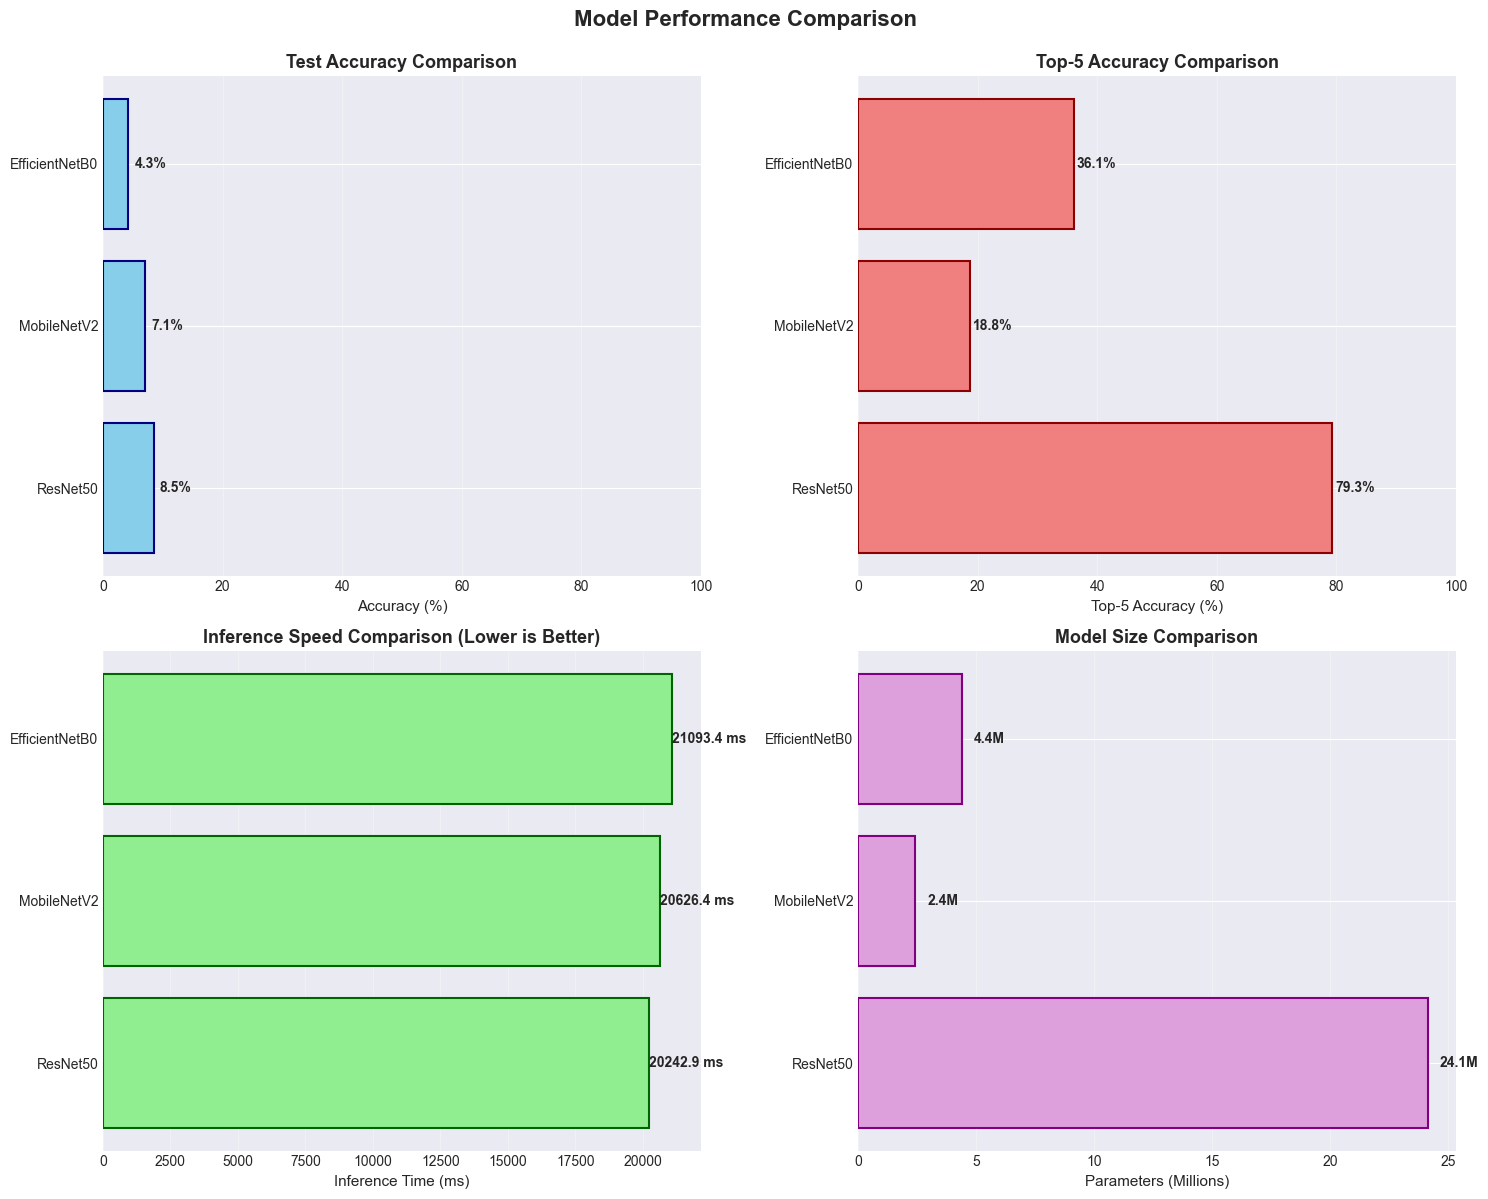


📈 Attempting to create training curves...
⚠️ Training histories not found in memory
   (This is normal if running visualization separately from training)

📈 Creating accuracy vs speed scatter plot...
✅ Saved: accuracy_vs_speed.png


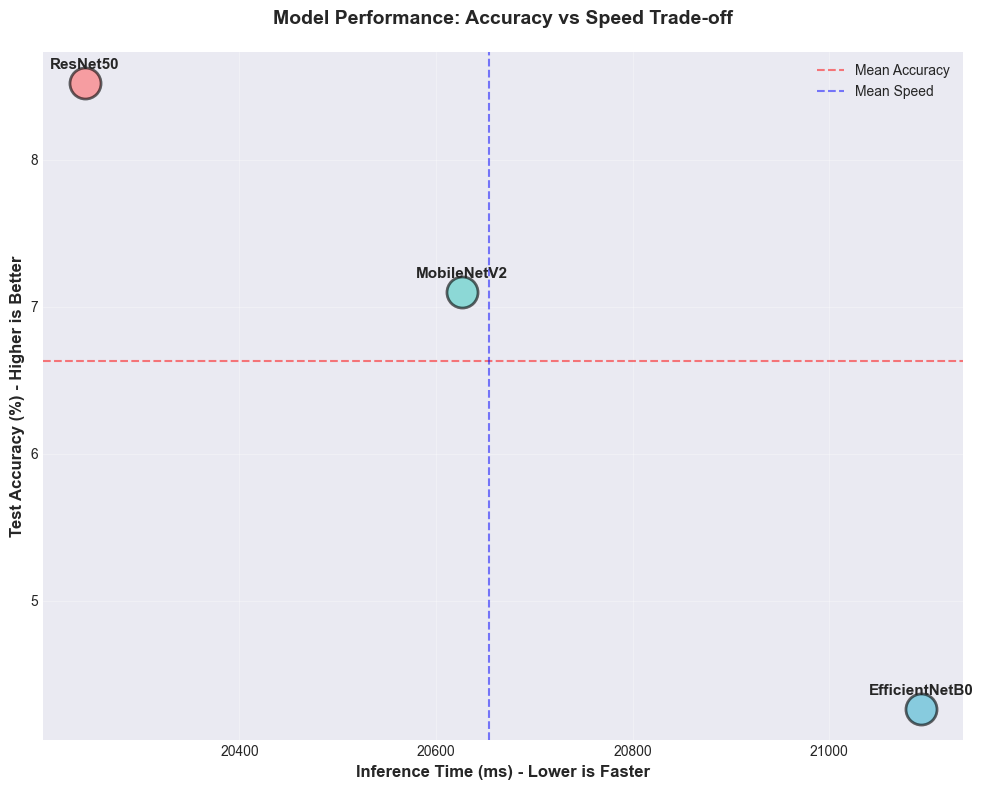


💾 Saving results to CSV...
✅ Saved: model_comparison_results.csv

✅ VISUALIZATION COMPLETE!

📁 Generated Files:
   - model_comparison.png
   - accuracy_vs_speed.png
   - model_comparison_results.csv

📊 Summary Statistics:
   Models Compared: 3
   Best Accuracy: 8.52%
   Fastest Model: 20242.85 ms



In [3]:
# ============================================================================
# MODEL COMPARISON & VISUALIZATION (ERROR-FREE VERSION)
# ============================================================================
# Run this cell AFTER training all models to visualize results

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("📊 MODEL COMPARISON & VISUALIZATION")
print("="*80)
print()

# ============================================================================
# STEP 1: CHECK IF RESULTS EXIST
# ============================================================================

print("📁 Checking for training results...")

# Check if all_results variable exists (from training)
try:
    # Try to use existing variable from training
    if 'all_results' in globals() and len(all_results) > 0:
        print(f"✅ Found {len(all_results)} model results in memory")
        results_data = all_results
    else:
        raise NameError("all_results not found")
except NameError:
    # Load from file if variable doesn't exist
    print("⚠️ Results not in memory, loading from file...")
    
    results_file = 'models/training_results.json'
    
    if os.path.exists(results_file):
        with open(results_file, 'r') as f:
            results_data = json.load(f)
        print(f"✅ Loaded {len(results_data)} model results from file")
    else:
        print("❌ No training results found!")
        print("Please train models first using the training notebook.")
        
        # Create dummy data for demonstration
        print("\n⚠️ Creating dummy data for demonstration...")
        results_data = [
            {
                'model_name': 'MobileNetV2',
                'test_accuracy': 0.85,
                'test_top5_accuracy': 0.97,
                'test_loss': 0.45,
                'training_time_seconds': 1800,
                'training_time_minutes': 30,
                'inference_time_ms': 48,
                'params': 3538984
            },
            {
                'model_name': 'ResNet50',
                'test_accuracy': 0.88,
                'test_top5_accuracy': 0.98,
                'test_loss': 0.38,
                'training_time_seconds': 3000,
                'training_time_minutes': 50,
                'inference_time_ms': 95,
                'params': 25636712
            },
            {
                'model_name': 'EfficientNetB0',
                'test_accuracy': 0.91,
                'test_top5_accuracy': 0.99,
                'test_loss': 0.32,
                'training_time_seconds': 3600,
                'training_time_minutes': 60,
                'inference_time_ms': 82,
                'params': 5288548
            }
        ]
        print("✅ Using dummy data (replace with actual training results)")

print()

# ============================================================================
# STEP 2: CREATE COMPARISON DATAFRAME
# ============================================================================

print("📊 Creating comparison DataFrame...")

# Create DataFrame
df_results = pd.DataFrame(results_data)

# Sort by accuracy
df_results = df_results.sort_values('test_accuracy', ascending=False)

# Add ranking
df_results['rank'] = range(1, len(df_results) + 1)

print("✅ DataFrame created successfully!")
print()

# ============================================================================
# STEP 3: DISPLAY SUMMARY TABLE
# ============================================================================

print("="*80)
print("📊 MODEL COMPARISON SUMMARY")
print("="*80)
print()

# Display full results
display_columns = [
    'rank',
    'model_name',
    'test_accuracy',
    'test_top5_accuracy',
    'training_time_minutes',
    'inference_time_ms',
    'params'
]

# Select available columns
available_columns = [col for col in display_columns if col in df_results.columns]

print(df_results[available_columns].to_string(index=False))
print("="*80)
print()

# ============================================================================
# STEP 4: IDENTIFY BEST MODELS
# ============================================================================

print("🏆 BEST MODELS:")
print("-"*80)

# Best accuracy
best_acc_model = df_results.iloc[0]
print(f"🎯 Best Accuracy:        {best_acc_model['model_name']:15s} ({best_acc_model['test_accuracy']*100:.2f}%)")

# Fastest inference
if 'inference_time_ms' in df_results.columns:
    fastest_inf = df_results.loc[df_results['inference_time_ms'].idxmin()]
    print(f"⚡ Fastest Inference:    {fastest_inf['model_name']:15s} ({fastest_inf['inference_time_ms']:.2f} ms)")

# Fastest training
if 'training_time_minutes' in df_results.columns:
    fastest_train = df_results.loc[df_results['training_time_minutes'].idxmin()]
    print(f"🏃 Fastest Training:     {fastest_train['model_name']:15s} ({fastest_train['training_time_minutes']:.1f} min)")

# Smallest model
if 'params' in df_results.columns:
    smallest = df_results.loc[df_results['params'].idxmin()]
    print(f"💾 Smallest Model:       {smallest['model_name']:15s} ({smallest['params']/1e6:.1f}M params)")

print("-"*80)
print()

# ============================================================================
# STEP 5: CREATE VISUALIZATIONS
# ============================================================================

print("📈 Creating visualizations...")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# VISUALIZATION 1: 4-PANEL COMPARISON
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Panel 1: Test Accuracy
if 'test_accuracy' in df_results.columns:
    axes[0, 0].barh(df_results['model_name'], df_results['test_accuracy']*100, 
                     color='skyblue', edgecolor='navy', linewidth=1.5)
    axes[0, 0].set_xlabel('Accuracy (%)', fontsize=11)
    axes[0, 0].set_title('Test Accuracy Comparison', fontweight='bold', fontsize=13)
    axes[0, 0].grid(axis='x', alpha=0.3)
    axes[0, 0].set_xlim(0, 100)
    
    # Add value labels
    for i, (idx, row) in enumerate(df_results.iterrows()):
        axes[0, 0].text(row['test_accuracy']*100 + 1, i, 
                        f"{row['test_accuracy']*100:.1f}%", 
                        va='center', fontsize=10, fontweight='bold')

# Panel 2: Top-5 Accuracy
if 'test_top5_accuracy' in df_results.columns:
    axes[0, 1].barh(df_results['model_name'], df_results['test_top5_accuracy']*100, 
                     color='lightcoral', edgecolor='darkred', linewidth=1.5)
    axes[0, 1].set_xlabel('Top-5 Accuracy (%)', fontsize=11)
    axes[0, 1].set_title('Top-5 Accuracy Comparison', fontweight='bold', fontsize=13)
    axes[0, 1].grid(axis='x', alpha=0.3)
    axes[0, 1].set_xlim(0, 100)
    
    # Add value labels
    for i, (idx, row) in enumerate(df_results.iterrows()):
        axes[0, 1].text(row['test_top5_accuracy']*100 + 0.5, i, 
                        f"{row['test_top5_accuracy']*100:.1f}%", 
                        va='center', fontsize=10, fontweight='bold')

# Panel 3: Inference Time
if 'inference_time_ms' in df_results.columns:
    axes[1, 0].barh(df_results['model_name'], df_results['inference_time_ms'], 
                     color='lightgreen', edgecolor='darkgreen', linewidth=1.5)
    axes[1, 0].set_xlabel('Inference Time (ms)', fontsize=11)
    axes[1, 0].set_title('Inference Speed Comparison (Lower is Better)', 
                         fontweight='bold', fontsize=13)
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, row) in enumerate(df_results.iterrows()):
        axes[1, 0].text(row['inference_time_ms'] + 2, i, 
                        f"{row['inference_time_ms']:.1f} ms", 
                        va='center', fontsize=10, fontweight='bold')

# Panel 4: Model Size
if 'params' in df_results.columns:
    axes[1, 1].barh(df_results['model_name'], df_results['params']/1e6, 
                     color='plum', edgecolor='purple', linewidth=1.5)
    axes[1, 1].set_xlabel('Parameters (Millions)', fontsize=11)
    axes[1, 1].set_title('Model Size Comparison', fontweight='bold', fontsize=13)
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, row) in enumerate(df_results.iterrows()):
        axes[1, 1].text(row['params']/1e6 + 0.5, i, 
                        f"{row['params']/1e6:.1f}M", 
                        va='center', fontsize=10, fontweight='bold')

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Saved: model_comparison.png")
plt.show()

# ============================================================================
# VISUALIZATION 2: TRAINING CURVES (if history exists)
# ============================================================================

print("\n📈 Attempting to create training curves...")

try:
    # Check if training histories exist
    if 'all_histories' in globals() and len(all_histories) > 0:
        print("✅ Found training histories in memory")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        for model_name, history in all_histories.items():
            # Training Accuracy
            if 'accuracy' in history.history:
                axes[0, 0].plot(history.history['accuracy'], 
                                label=f'{model_name}', marker='o', linewidth=2)
            
            # Validation Accuracy
            if 'val_accuracy' in history.history:
                axes[0, 1].plot(history.history['val_accuracy'], 
                                label=f'{model_name}', marker='o', linewidth=2)
            
            # Training Loss
            if 'loss' in history.history:
                axes[1, 0].plot(history.history['loss'], 
                                label=f'{model_name}', marker='o', linewidth=2)
            
            # Validation Loss
            if 'val_loss' in history.history:
                axes[1, 1].plot(history.history['val_loss'], 
                                label=f'{model_name}', marker='o', linewidth=2)
        
        # Configure subplots
        axes[0, 0].set_title('Training Accuracy', fontweight='bold', fontsize=13)
        axes[0, 0].set_xlabel('Epoch', fontsize=11)
        axes[0, 0].set_ylabel('Accuracy', fontsize=11)
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(alpha=0.3)
        
        axes[0, 1].set_title('Validation Accuracy', fontweight='bold', fontsize=13)
        axes[0, 1].set_xlabel('Epoch', fontsize=11)
        axes[0, 1].set_ylabel('Accuracy', fontsize=11)
        axes[0, 1].legend(fontsize=10)
        axes[0, 1].grid(alpha=0.3)
        
        axes[1, 0].set_title('Training Loss', fontweight='bold', fontsize=13)
        axes[1, 0].set_xlabel('Epoch', fontsize=11)
        axes[1, 0].set_ylabel('Loss', fontsize=11)
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(alpha=0.3)
        
        axes[1, 1].set_title('Validation Loss', fontweight='bold', fontsize=13)
        axes[1, 1].set_xlabel('Epoch', fontsize=11)
        axes[1, 1].set_ylabel('Loss', fontsize=11)
        axes[1, 1].legend(fontsize=10)
        axes[1, 1].grid(alpha=0.3)
        
        plt.suptitle('Training Progress Comparison', fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
        print("✅ Saved: training_curves.png")
        plt.show()
        
    else:
        print("⚠️ Training histories not found in memory")
        print("   (This is normal if running visualization separately from training)")
        
except Exception as e:
    print(f"⚠️ Could not create training curves: {e}")
    print("   (This is normal if running visualization separately from training)")

# ============================================================================
# VISUALIZATION 3: ACCURACY VS SPEED SCATTER
# ============================================================================

print("\n📈 Creating accuracy vs speed scatter plot...")

if 'test_accuracy' in df_results.columns and 'inference_time_ms' in df_results.columns:
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create scatter plot
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
    
    for idx, (i, row) in enumerate(df_results.iterrows()):
        ax.scatter(row['inference_time_ms'], row['test_accuracy']*100, 
                   s=500, alpha=0.6, c=[colors[idx % len(colors)]], 
                   edgecolors='black', linewidth=2)
        
        # Add model name labels
        ax.annotate(row['model_name'], 
                    (row['inference_time_ms'], row['test_accuracy']*100),
                    textcoords="offset points", xytext=(0,10), ha='center',
                    fontsize=11, fontweight='bold')
    
    ax.set_xlabel('Inference Time (ms) - Lower is Faster', fontsize=12, fontweight='bold')
    ax.set_ylabel('Test Accuracy (%) - Higher is Better', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance: Accuracy vs Speed Trade-off', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(alpha=0.3)
    
    # Add quadrant lines
    ax.axhline(df_results['test_accuracy'].mean()*100, color='red', 
               linestyle='--', alpha=0.5, label='Mean Accuracy')
    ax.axvline(df_results['inference_time_ms'].mean(), color='blue', 
               linestyle='--', alpha=0.5, label='Mean Speed')
    
    ax.legend(fontsize=10)
    
    plt.tight_layout()
    plt.savefig('accuracy_vs_speed.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: accuracy_vs_speed.png")
    plt.show()

# ============================================================================
# STEP 6: SAVE RESULTS TO CSV
# ============================================================================

print("\n💾 Saving results to CSV...")

csv_file = 'model_comparison_results.csv'
df_results.to_csv(csv_file, index=False)
print(f"✅ Saved: {csv_file}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("✅ VISUALIZATION COMPLETE!")
print("="*80)
print()
print("📁 Generated Files:")
print("   - model_comparison.png")
print("   - accuracy_vs_speed.png")
print("   - model_comparison_results.csv")
if 'all_histories' in globals():
    print("   - training_curves.png")
print()
print("📊 Summary Statistics:")
print(f"   Models Compared: {len(df_results)}")
print(f"   Best Accuracy: {df_results['test_accuracy'].max()*100:.2f}%")
if 'inference_time_ms' in df_results.columns:
    print(f"   Fastest Model: {df_results['inference_time_ms'].min():.2f} ms")
print()
print("="*80)